In [1]:
import logging
import os
import pdb
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image # animated gif
from tqdm import tqdm

import G211
from ml_functions import brier_skill_score, get_argparser, get_flash_pred
from statisticplot import make_map, stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

2023-12-17 14:58:58.959970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 14:58:59.110676: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tmpdir = Path(os.getenv("TMPDIR"))
# map projection
map_crs = G211.g211
grid = G211.grid
conus_mask = G211.mask

obsvar = "cg.ic"
o_thresh = 1
twin = 4
rptdist = 20
clobber = False

platform = "glm" if obsvar == "flashes" else "wbug"
f = f"{obsvar}_{rptdist}km_{twin}hr"

teststart = "20201202"
testend = "20220101"
parser = get_argparser()
# use [0, 1, 2] time windows for ['sighail', 'sigwind', 'hailone', 'wind', 'torn']
# until we update parquet files with [1,2,4]
rpttwin = int(
    np.floor(twin / 2)
)  # Ryan's original way of naming storm rpt time windows
args = parser.parse_args(
    args="--seed -1 --model HRRR --batchsize 1024 --neurons 1024 --optim Adam"
    " --trainstart 20191002 --trainend 20201202 "
    f"--teststart {teststart} --testend {testend} "
    f"--flash {o_thresh} "
    f"--twin {twin} "
    f"--savedmodel /glade/work/ahijevyc/NSC_objects/nn/lightning/{o_thresh:03d}+.{twin}hr "
    "--labels "
    # f"sighail_{rptdist}km_{rpttwin}hr sigwind_{rptdist}km_{rpttwin}hr "
    # f"hailone_{rptdist}km_{rpttwin}hr wind_{rptdist}km_{rpttwin}hr torn_{rptdist}km_{rpttwin}hr any_{rptdist}km_{rpttwin}hr "
    f"cg_20km_{twin}hr ic_20km_{twin}hr cg.ic_20km_{twin}hr flashes_20km_{twin}hr "
    f"cg_40km_{twin}hr ic_40km_{twin}hr cg.ic_40km_{twin}hr flashes_40km_{twin}hr "
    "--batchnorm "
    "--reg_penalty 0 "
    " --epoch 30 --learning 0.001 --kfold 1".split()
)

args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('2019-10-02 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 00:00:00'), twin=4, suite='default')

In [3]:
Y = get_flash_pred(args, clobber=clobber)

levels = sorted(
    list(set(Y.index.names) - {"fold", "fit"})
)  # sorted puts forecast_hour first
assert levels[0] == "forecast_hour"

2023-12-17 14:59:01,807 read saved model output /glade/derecho/scratch/ahijevyc/tmp/Y.001+4hr.2020-12-02 00:00:00-2022-01-01 00:00:00.par
2023-12-17 15:00:18,743 done


In [4]:
import sklearn


def stats(df, o_thresh):
    labels = df.xs("y_label", axis="columns", level=0) >= o_thresh
    y_pred = df.xs("y_pred", axis="columns", level=0)
    bss = brier_skill_score(labels, y_pred)

    auc = pd.Series(np.nan, index=labels.columns)
    aps = auc.copy()
    TF = labels.nunique() == 2
    if TF.any():
        auc[TF] = sklearn.metrics.roc_auc_score(
            labels.loc[:, TF], y_pred.loc[:, TF], average=None
        )
        aps[TF] = sklearn.metrics.average_precision_score(
            labels.loc[:, TF], y_pred.loc[:, TF], average=None
        )

    df = pd.DataFrame(
        {
            "bss": bss,
            "base_rate": labels.mean(),
            "auc": auc,
            "aps": aps,
            "n": y_pred.count(),
        }
    )
    df.index.name = "class"
    return df


def label_pts(ax):
    if ax.get_xlim()[1] - ax.get_xlim()[0] > 10:
        return ax
    xy = ax.lines[0].get_xydata()
    for x0, y0 in xy:
        ax.text(x0, y0, f"{y0:.4f}", clip_on=True, ha="center", fontsize=7)
    return ax

In [5]:
ensmean = (
    Y.xs(slice(25, 48), level="forecast_hour", drop_level=False)
    .groupby(level=levels)
    .mean()
)

logging.warning("apply stats")
tqdm.pandas()
s = ensmean.groupby("valid_time").apply(stats, o_thresh)

2023-12-17 15:01:14,169 apply stats


In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(13, 10), sharex=True)
data = s.xs("cg.ic_20km_4hr", level="class")
x = "valid_time"
hue = None
ax = sns.lineplot(
    ax=axes[0],
    data=data,
    x=x,
    hue=hue,
    y="bss",
)
ax.set_ylim(bottom=0, top=0.8)
if len(ax.lines) > 1:
    sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(left=pd.to_datetime("20210619"), right=pd.to_datetime("20210821"))
ax = sns.lineplot(
    ax=axes[1],
    data=data,
    x=x,
    hue=hue,
    y="base_rate",
)
sns.lineplot(
    ax=axes[2],
    data=data,
    x=x,
    hue=hue,
    y="aps",
)
ax = sns.lineplot(
    ax=axes[3],
    data=data,
    x=x,
    hue=hue,
    y="auc",
)
ax.set_ylim((0.78, 0.96))
#ax = sns.lineplot(
#    ax=axes[4],
#    data=data,
#    x=x,
#    hue=hue,
#    y="n",
#)
for ax in axes:
    ax.lines[0].set_marker(".")
    ax.axvline(x = pd.to_datetime("20210621T14"), color="red")
    ax.axvline(x = pd.to_datetime("20210630T12"), color="red")
    ax.axvline(x = pd.to_datetime("20210707T14"), color="red")
    ax.axvline(x = pd.to_datetime("20210811T04"), color="red")

    label_pts(ax)

forecast hours [28]


2023-12-17 14:30:22,516 /glade/derecho/scratch/ahijevyc/tmp/dnn_o.png


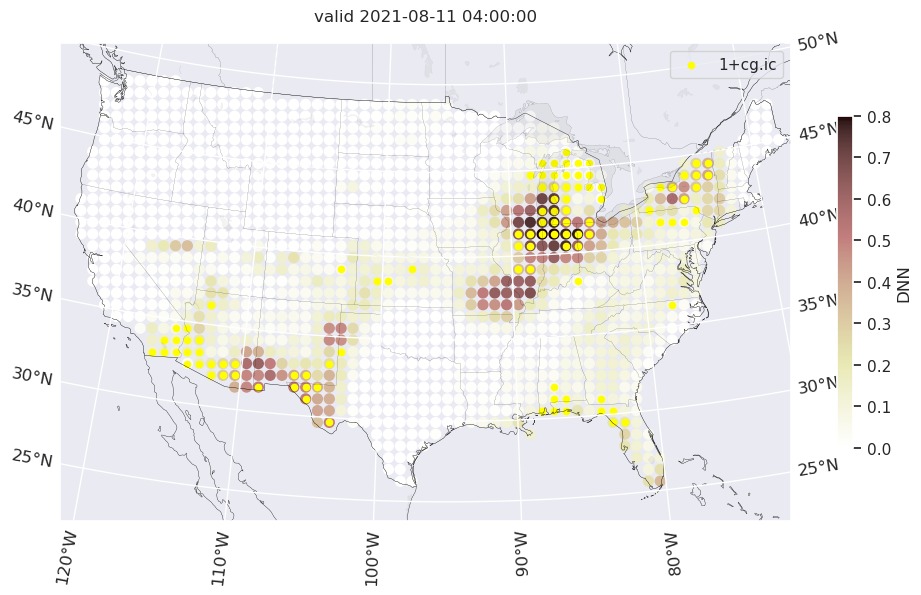

In [49]:
valid_time = pd.to_datetime("2021-08-11 04:00:00")
df = ensmean.xs(
    valid_time,
    level="valid_time",
    drop_level=False,
)
print(f"forecast hours {df.reset_index().forecast_hour.unique()}")

fig, ax = make_map(projection=map_crs)

def getp(Y):
    """
    probability of no occurences during long time window = product of 1-p for all
    smaller time window pieces
    """

    # multiply members of group (analogous to sum)
    prob_none = (1 - Y).groupby(["y", "x", "lat", "lon"]).prod()
    # 1 minus prob_none = prob of at least one occurence.
    p = 1 - prob_none
    p = p.reset_index()
    return p


p = getp(df.xs("y_pred", axis="columns", level=0))
obs = df.xs("y_label", axis="columns", level=0)

px = p.plot(
    ax=ax,
    cmap="pink_r",
    c=f,
    kind="scatter",
    x="lon",
    y="lat",
    s=50,
    marker="o",
    transform=ccrs.PlateCarree(),
    vmax=0.8,
    colorbar=False,
)
fig.colorbar(px.collections[0], shrink=0.5, label="DNN")

ax.set_title(
    f"valid {valid_time}"
)

o = (obs.groupby(["y", "x", "lat", "lon"]).sum() >= o_thresh).reset_index()
i = obs.groupby(["y", "x"]).sum()[f].values > o_thresh
ox = o.loc[i].plot(
    ax=ax,
    kind="scatter",
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    marker="o",
    color="yellow",
    label=f"{o_thresh}+{obsvar}",
)
leg = ox.legend()
ofile = tmpdir / "dnn_o.png"
plt.tight_layout()
fig.savefig(ofile)
logging.warning(ofile)

0.1416


2023-12-17 14:30:23,349 /glade/derecho/scratch/ahijevyc/tmp/t.png


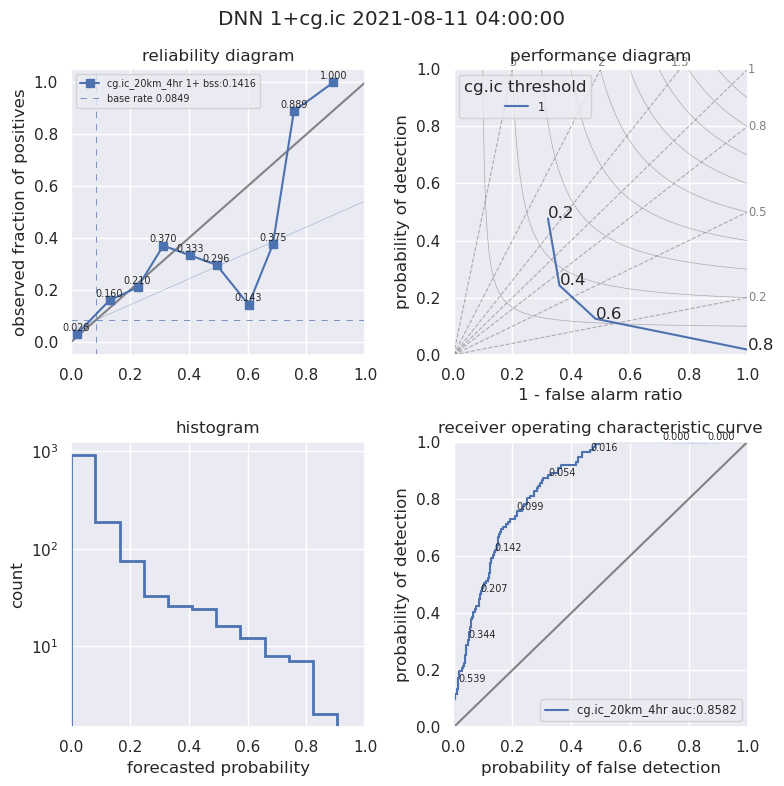

In [50]:
fcst = p[f]
obs = o[f]

fig = stat_plots(
    obs,
    fcst,
    thresh=pd.Series([o_thresh], name=f"{obsvar} threshold"),
    pthresh=pd.Series(np.round(np.arange(0.2, 1, 0.2), 2), name=f"fcst\np thresh"),
    o_thresh=o_thresh,
    sep=0.15,
    n_bins=11,
    suptitle=(f"DNN {o_thresh}+{obsvar} {valid_time}"),
)

ofile = tmpdir / "t.png"
fig.savefig(ofile)
logging.warning(ofile)

In [51]:
from zarr_hrrr import ZarrId, load_combined_dataset

initial_time = df.index.get_level_values("initialization_time").mean()
history_time = df.index.get_level_values("valid_time").mean().round(freq="1H")

In [52]:
root_url = initial_time.strftime("s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_fcst.zarr")

var_name = "REFC"
var_level = "entire_atmosphere"

zarr_id = ZarrId(
    run_hour=initial_time,
    level_type="sfc",
    var_level=var_level,
    var_name=var_name,
    model_type="fcst",
)
ds = load_combined_dataset([zarr_id])
cvar = ds.sel(reference_time=initial_time, time=history_time)[var_name]

2023-12-17 14:30:29,138 /glade/derecho/scratch/ahijevyc/tmp/hrrr.png


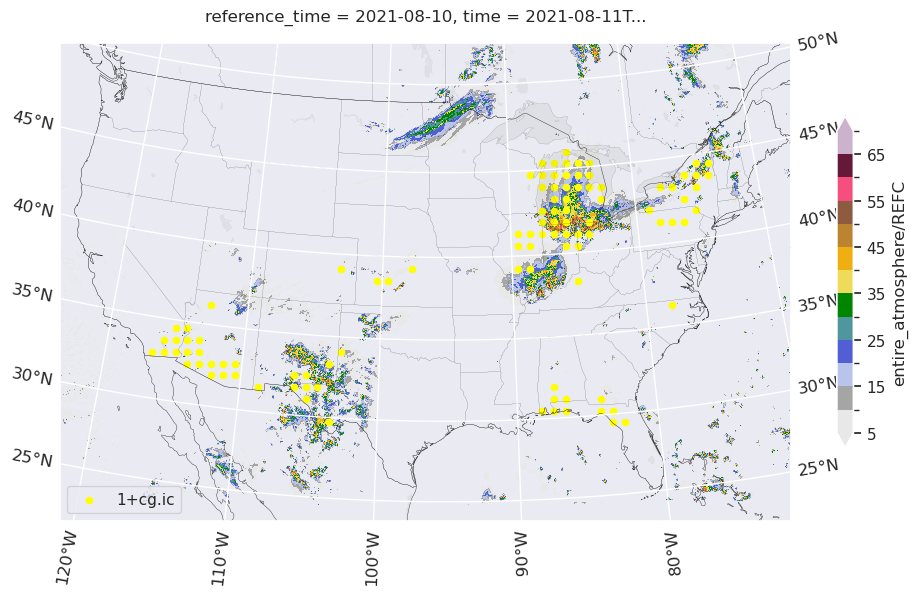

In [53]:
import fieldinfo

fig, ax = make_map(projection=map_crs)
clevels = range(5, 75, 5)
cmap = colors.ListedColormap(
    fieldinfo.readcm("/glade/u/home/sobash/hwt2020_graphics/cmap_rad.rgb", projdir="")
)
norm = colors.BoundaryNorm(clevels, cmap.N)
cvar.where(cvar > 0).plot(
    ax=ax,
    levels=clevels,
    cmap=cmap,
    norm=norm,
    cbar_kwargs={"shrink": 0.5},
)

ox = (
    o.loc[i]
    .plot(
        ax=ax,
        kind="scatter",
        x="lon",
        y="lat",
        transform=ccrs.PlateCarree(),
        marker="o",
        color="yellow",
        label=f"{o_thresh}+{obsvar}",
        # legend=False, # placement takes forever
    )
    .legend(loc="lower left")
)
#ax.set_extent((-117, -72, 24.5, 48.5))
ofile = tmpdir / "hrrr.png"
plt.tight_layout()
plt.savefig(ofile)
logging.warning(ofile)

In [54]:
import urllib.request

from PIL import Image as pImage

images = [
    urllib.request.urlretrieve(
        t.strftime(
            "https://www2.mmm.ucar.edu/imagearchive1/RadarComposites/national/%Y%m%d/national_%Y%m%d%H%M.gif"
        ),
        tmpdir / t.strftime("%Y%m%d%H%M.gif"),
    )
    for t in pd.date_range(start=valid_time-pd.Timedelta(hours=twin)/2, end=valid_time+pd.Timedelta(hours=twin)/2, freq="30T")
]

2023-12-17 14:30:31,181 /glade/derecho/scratch/ahijevyc/tmp/anim.gif


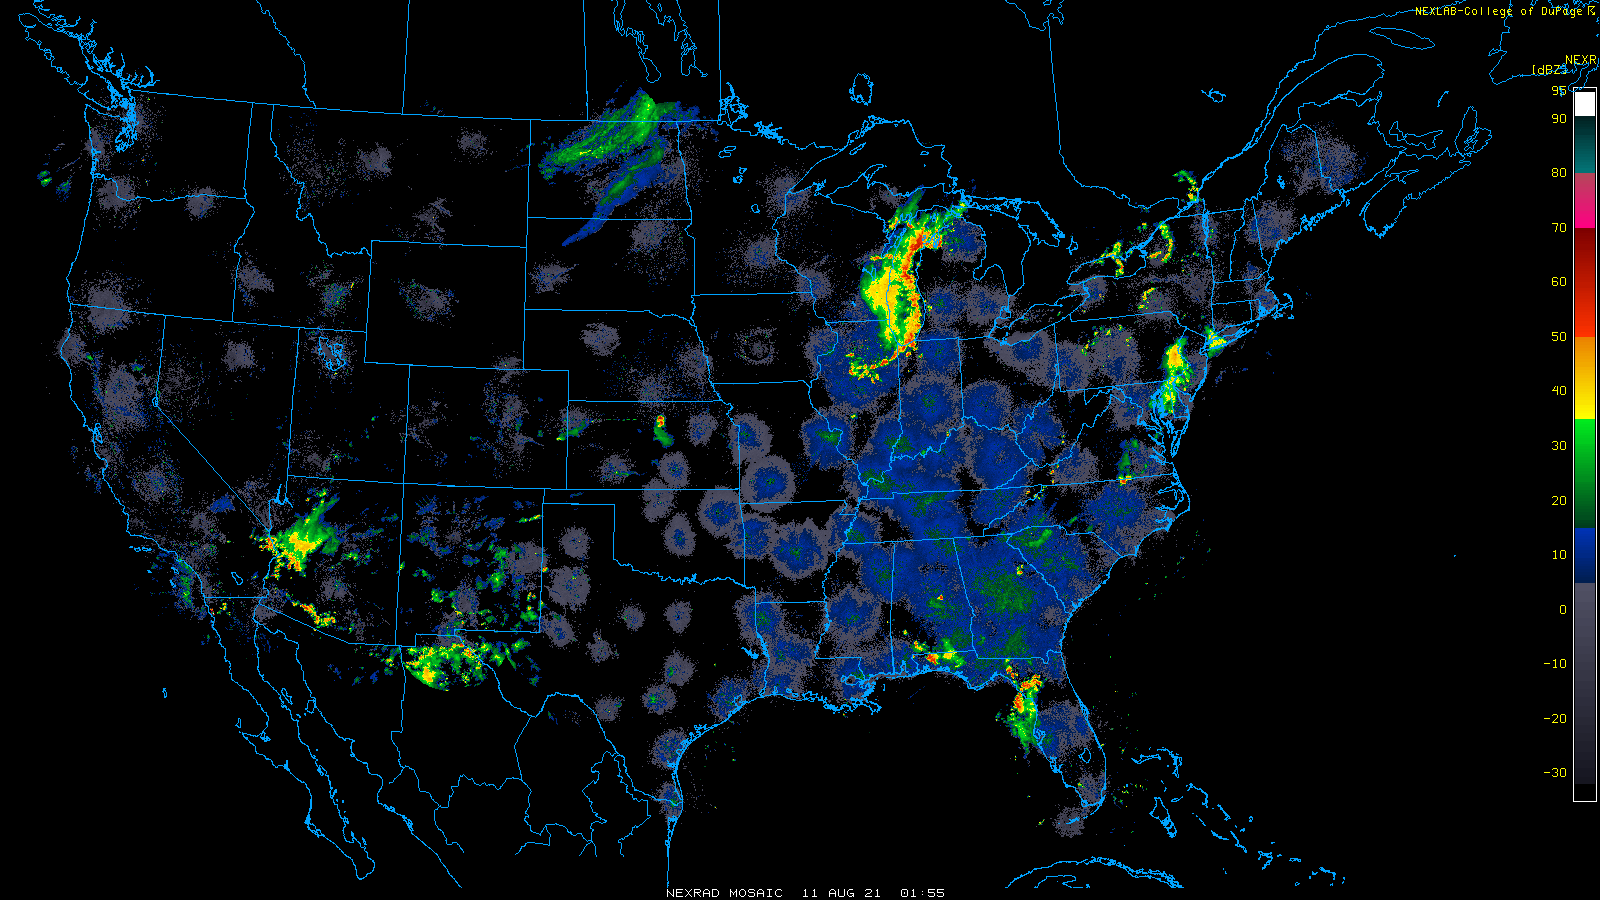

In [55]:
frames = [pImage.open(image) for image, msg in images]
frame_one = frames[0]
ofile = tmpdir/"anim.gif"
frame_one.save(
    ofile, format="GIF", append_images=frames, save_all=True, duration=250, loop=0
)
logging.warning(ofile)
Image(open(ofile, "rb").read())